In [102]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from scipy import stats
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error
import operator

In [103]:
#Đọc dữ liệu từ file CSV
df = pd.read_csv(r'redfin_housing.csv')

### Mô tả:
Data về giá nhà của các thành phố lớn ở Mỹ với các cột:
- **Price (USD):** giá nhà
- **City:**: Tên thành phố
- **Date:**: Ngày
- **Beds:** Số lượng phòng ngủ
- **Baths:** Số lượng phòng tắm
- **Area (SQFT):** Diện tích căn nhà

In [104]:
df.head()

,Price (USD),City,Date,Beds,Baths,Area (SQFT)
0,875000.0,Los-Angeles,12/15/2023,2.0,2.0,1343
1,750000.0,Los-Angeles,12/15/2023,3.0,2.5,1454
2,1699000.0,Los-Angeles,12/15/2023,4.0,2.0,2085
3,460000.0,Los-Angeles,12/15/2023,2.0,2.0,1193
4,857000.0,Los-Angeles,12/15/2023,3.0,2.0,1635


### Xử lý dữ liệu:
- Chọn ra 4 thành phố có nhiều dữ liệu nhất
- Loại bỏ cột **Date** trong dữ liệu (vì không sử dụng nó)

In [105]:
#Chọn ra 4 thành phố có dữ liệu lớn
city = df['City'].value_counts().index[:4]

#Chỉ giữ lại 4 thành phố
df = df.loc[df['City'].isin(city)]

#xóa cột ngày
df = df.drop('Date', axis=1)

### Loại bỏ Outliers không cần thiết:
- Sử dụng các khoảng **25% | 50% | 75%** cho tất cả các cột
- Sử dụng công thức tìm Outliers:
$$IQR = Q3 - Q1$$
$$point remove > Q3 + 1.5*IQR$$
$$point remove < Q1 - 1.5*IQR$$

In [106]:
#Tính Quantiers 25% - 50% - 75%
q_price = df['Price (USD)'].quantile([0.25, 0.5, 0.75])
q_bed = df['Beds'].quantile([0.25, 0.5, 0.75])
q_bath = df['Baths'].quantile([0.25, 0.5, 0.75])
q_area = df['Area (SQFT)'].quantile([0.25, 0.5, 0.75])

In [107]:
#Tạo Series cho các quantiers với q_low và q_high
q_price = pd.Series({
    'q_low': q_price.iloc[0] - 1.5*(q_price.iloc[2] - q_price.iloc[0]),
    'q_high': q_price.iloc[2] + 1.5*(q_price.iloc[2] - q_price.iloc[0])
})
q_beds = pd.Series({
    'q_low': q_bed.iloc[0] - 1.5*(q_bed.iloc[2] - q_bed.iloc[0]),
    'q_high': q_bed.iloc[2] + 1.5*(q_bed.iloc[2] - q_bed.iloc[0])
})
q_bath = pd.Series({
    'q_low': q_bath.iloc[0] - 1.5*(q_bath.iloc[2] - q_bath.iloc[0]),
    'q_high': q_bath.iloc[2] + 1.5*(q_bath.iloc[2] - q_bath.iloc[0])
})
q_area = pd.Series({
    'q_low': q_area.iloc[0] - 1.5*(q_area.iloc[2] - q_area.iloc[0]),
    'q_high': q_area.iloc[2] + 1.5*(q_area.iloc[2] - q_area.iloc[0])
})

In [108]:
#Tạo DataFrame với cột là Price, Beds, Baths, Area
quantiers = pd.DataFrame({'Price': q_price, 'Beds': q_beds, 'Baths': q_bath, 'Area': q_area})

In [109]:
quantiers

,Price,Beds,Baths,Area
q_low,-300000.0,1.5,0.5,66.0
q_high,1420000.0,5.5,4.5,3602.0


In [110]:
#Tinh chỉnh lại dataFrame khi bỏ bớt data nằm ngoài Outliers
df_modify = df.loc[
    ((df['Price (USD)'] >= quantiers['Price'].iloc[0]) & (df['Price (USD)'] <= quantiers['Price'].iloc[1])) &
    ((df['Beds'] >= quantiers['Beds'].iloc[0]) & (df['Beds'] <= quantiers['Beds'].iloc[1])) &
    ((df['Baths'] >= quantiers['Baths'].iloc[0]) & (df['Baths'] <= quantiers['Baths'].iloc[1])) &
    ((df['Area (SQFT)'] >= quantiers['Area'].iloc[0]) & (df['Area (SQFT)'] <= quantiers['Area'].iloc[1]))
]

In [111]:
df_modify

,Price (USD),City,Beds,Baths,Area (SQFT)
0,875000.0,Los-Angeles,2.0,2.00,1343
1,750000.0,Los-Angeles,3.0,2.50,1454
3,460000.0,Los-Angeles,2.0,2.00,1193
4,857000.0,Los-Angeles,3.0,2.00,1635
5,880000.0,Los-Angeles,4.0,2.00,1885
...,...,...,...,...,...
2765,249900.0,Phoenix,3.0,1.50,1008
2766,425000.0,Phoenix,3.0,2.00,1931
2767,350000.0,Phoenix,4.0,2.50,1471
2768,400000.0,Phoenix,4.0,2.00,1713


1. Ước lượng:

- Ước lượng điểm để tìm giá trị trung bình của giá bán, diện tích, số lượng phòng ngủ và phòng tắm.

- Ước lượng khoảng (khoảng tin cậy) để ước lượng trung bình của giá bán hoặc diện tích với độ tin cậy nhất định.

2. Kiểm định giả thuyết:

- Kiểm định xem có sự khác biệt đáng kể nào về giá bán trung bình giữa các thành phố không.

- Kiểm định xem số phòng ngủ hoặc phòng tắm trung bình có khác biệt đáng kể so với một giá trị giả định nào đó.

3. Phân tích hồi quy:

- Sử dụng hồi quy tuyến tính để mô hình hóa mối quan hệ giữa giá bán với diện tích, số phòng ngủ và phòng tắm.

- Kiểm tra xem liệu diện tích và các yếu tố khác (như số phòng ngủ, phòng tắm) có thể dự đoán giá bán một cách có ý nghĩa hay không.

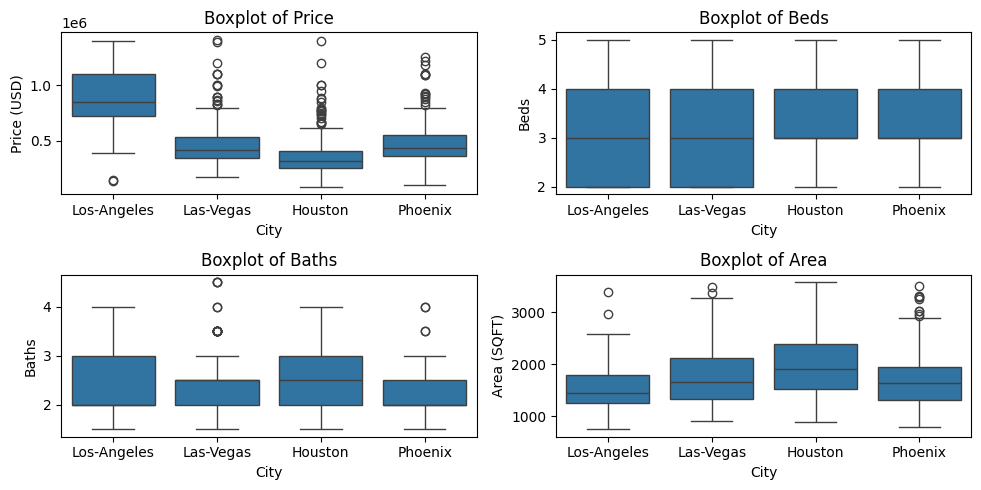

In [112]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(10, 5))

sns.boxplot(df_modify, x='City', y='Price (USD)', ax=ax[0,0]).set_title('Boxplot of Price')
sns.boxplot(df_modify, x='City', y='Beds', ax=ax[0,1]).set_title('Boxplot of Beds')
sns.boxplot(df_modify, x='City', y='Baths', ax=ax[1,0]).set_title('Boxplot of Baths')
sns.boxplot(df_modify, x='City', y='Area (SQFT)', ax=ax[1,1]).set_title('Boxplot of Area')

plt.tight_layout()

# Ước lượng

## Ước lượng điểm sample

In [113]:
# Calculate point estimates (mean) for key features
point_estimates = {
    'Giá nhà trung bình (USD)': round(df_modify['Price (USD)'].mean(), 3),
    'Diện tích trung bình (SQFT)': round(df_modify['Area (SQFT)'].mean(), 3),
    'Số phòng ngủ trung bình': round(df_modify['Beds'].mean(), 3),
    'Số phòng tắm trung bình': round(df_modify['Baths'].mean(), 3)
}

for key, value in point_estimates.items():
    print(f"{key}: {value}")


Giá nhà trung bình (USD): 515484.322
Diện tích trung bình (SQFT): 1768.138
Số phòng ngủ trung bình: 3.161
Số phòng tắm trung bình: 2.371


## Ước lượng khoảng sample

In [114]:
# Đặt mức độ tin cậy
confidence_level = 0.95
alpha = 1 - confidence_level

# Định nghĩa hàm để tính khoảng tin cậy (khi biết phương sai tổng thể)
def confidence_interval(data_column):
    n = len(data_column)  # Kích thước mẫu
    mean = np.mean(data_column) # Trung bình mẫu
    std_dev = np.std(data_column) # Độ lệch chuẩn tổng thể
    z_score = stats.norm.ppf(1 - alpha/2) #Khoảng tin cậy hai phía
    margin_error = z_score * (std_dev / np.sqrt(n)) # Sai số biên
    lower_bound = mean - margin_error # Giới hạn dưới
    upper_bound = mean + margin_error # Giới hạn trên
    return lower_bound, upper_bound

# Calculate confidence intervals for key metrics
price_ci = confidence_interval(df_modify['Price (USD)'])
area_ci = confidence_interval(df_modify['Area (SQFT)'])
beds_ci = confidence_interval(df_modify['Beds'])
baths_ci = confidence_interval(df_modify['Baths'])

# Formatting the results for clarity
formatted_confidence_intervals = {
    'Price (USD) 95% CI': f"{price_ci[0]:,.2f} to {price_ci[1]:,.2f}",
    'Area (SQFT) 95% CI': f"{area_ci[0]:,.2f} to {area_ci[1]:,.2f}",
    'Beds 95% CI': f"{beds_ci[0]:,.2f} to {beds_ci[1]:,.2f}",
    'Baths 95% CI': f"{baths_ci[0]:,.2f} to {baths_ci[1]:,.2f}"
}

for key, value in formatted_confidence_intervals.items():
    print(f"{key}: {value}")


Price (USD) 95% CI: 497,546.77 to 533,421.87
Area (SQFT) 95% CI: 1,731.03 to 1,805.25
Beds 95% CI: 3.11 to 3.21
Baths 95% CI: 2.34 to 2.41


## Ước lượng điểm cho từng thành phố

In [115]:
#Tạo dataFrame từng thành phố
los_angeles = df_modify.loc[df_modify['City'] == 'Los-Angeles']
las_vegas = df_modify.loc[df_modify['City'] == 'Las-Vegas']
houston = df_modify.loc[df_modify['City'] == 'Houston']
phoenix = df_modify.loc[df_modify['City'] == 'Phoenix']

### Ước lượng điểm cho từng thành phố

In [116]:
# Calculate point estimates (mean) for key features
point_estimates_los = {
    'Giá nhà trung bình của Los Angeles (USD)': round(los_angeles['Price (USD)'].mean(), 3),
    'Diện tích trung bình Los Angles (SQFT)': round(los_angeles['Area (SQFT)'].mean(), 3),
    'Số phòng ngủ trung bình Los Angles': round(los_angeles['Beds'].mean(), 3),
    'Số phòng tắm trung bình Los Angles': round(los_angeles['Baths'].mean(), 3)
}

for key, value in point_estimates_los.items():
    print(f"{key}: {value}")

Giá nhà trung bình của Los Angeles (USD): 896349.617
Diện tích trung bình Los Angles (SQFT): 1546.295
Số phòng ngủ trung bình Los Angles: 3.094
Số phòng tắm trung bình Los Angles: 2.369


In [117]:
# Calculate point estimates (mean) for key features
point_estimates_los = {
    'Giá nhà trung bình của Las Vegas (USD)': round(las_vegas['Price (USD)'].mean(), 3),
    'Diện tích trung bình Las Vegas (SQFT)': round(las_vegas['Area (SQFT)'].mean(), 3),
    'Số phòng ngủ trung bình Las Vegas': round(las_vegas['Beds'].mean(), 3),
    'Số phòng tắm trung bình Las Vegas': round(las_vegas['Baths'].mean(), 3)
}

for key, value in point_estimates_los.items():
    print(f"{key}: {value}")

Giá nhà trung bình của Las Vegas (USD): 466251.494
Diện tích trung bình Las Vegas (SQFT): 1768.069
Số phòng ngủ trung bình Las Vegas: 3.05
Số phòng tắm trung bình Las Vegas: 2.409


In [118]:
# Calculate point estimates (mean) for key features
point_estimates_los = {
    'Giá nhà trung bình của Houston (USD)': round(houston['Price (USD)'].mean(), 3),
    'Diện tích trung bình Houston (SQFT)': round(houston['Area (SQFT)'].mean(), 3),
    'Số phòng ngủ trung bình Houston': round(houston['Beds'].mean(), 3),
    'Số phòng tắm trung bình Houston': round(houston['Baths'].mean(), 3)
}

for key, value in point_estimates_los.items():
    print(f"{key}: {value}")

Giá nhà trung bình của Houston (USD): 368997.838
Diện tích trung bình Houston (SQFT): 1991.328
Số phòng ngủ trung bình Houston: 3.255
Số phòng tắm trung bình Houston: 2.523


In [119]:
# Calculate point estimates (mean) for key features
point_estimates_los = {
    'Giá nhà trung bình của Phoenix (USD)': round(phoenix['Price (USD)'].mean(), 3),
    'Diện tích trung bình Phoenix (SQFT)': round(phoenix['Area (SQFT)'].mean(), 3),
    'Số phòng ngủ trung bình Phoenix': round(phoenix['Beds'].mean(), 3),
    'Số phòng tắm trung bình Phoenix': round(phoenix['Baths'].mean(), 3)
}

for key, value in point_estimates_los.items():
    print(f"{key}: {value}")

Giá nhà trung bình của Phoenix (USD): 475595.558
Diện tích trung bình Phoenix (SQFT): 1687.4
Số phòng ngủ trung bình Phoenix: 3.229
Số phòng tắm trung bình Phoenix: 2.183


In [120]:
# Đặt mức độ tin cậy
confidence_level = 0.95
alpha = 1 - confidence_level

# Định nghĩa hàm để tính khoảng tin cậy (khi biết phương sai tổng thể)
def confidence_interval_known_variance(data_column):
    n = len(data_column)  # Kích thước mẫu
    mean = np.mean(data_column) # Trung bình mẫu
    std_dev = np.std(data_column) # Độ lệch chuẩn tổng thể
    z_score = stats.norm.ppf(1 - alpha/2) #Khoảng tin cậy hai phía
    margin_error = z_score * (std_dev / np.sqrt(n)) # Sai số biên
    lower_bound = mean - margin_error # Giới hạn dưới
    upper_bound = mean + margin_error # Giới hạn trên
    return lower_bound, upper_bound     

In [121]:
for column_name in ['Price (USD)', 'Area (SQFT)', 'Baths', 'Beds']:
        if column_name in los_angeles.columns and pd.api.types.is_numeric_dtype(los_angeles[column_name]):
            lower, upper = confidence_interval_known_variance(los_angeles[column_name])
            print(f"Khoảng ước lượng Los Angeles - cột {column_name}: ({lower:.2f}, {upper:.2f})") 

Khoảng ước lượng Los Angeles - cột Price (USD): (853534.42, 939164.81)
Khoảng ước lượng Los Angeles - cột Area (SQFT): (1477.59, 1615.00)
Khoảng ước lượng Los Angeles - cột Baths: (2.28, 2.46)
Khoảng ước lượng Los Angeles - cột Beds: (2.95, 3.23)


In [122]:
for column_name in ['Price (USD)', 'Area (SQFT)', 'Baths', 'Beds']: 
        if column_name in las_vegas.columns and pd.api.types.is_numeric_dtype(las_vegas[column_name]):
            lower, upper = confidence_interval_known_variance(las_vegas[column_name])
            print(f"Khoảng ước lượng Las Vegas - cột {column_name}: ({lower:.2f}, {upper:.2f})") 

Khoảng ước lượng Las Vegas - cột Price (USD): (441858.82, 490644.17)
Khoảng ước lượng Las Vegas - cột Area (SQFT): (1700.02, 1836.11)
Khoảng ước lượng Las Vegas - cột Baths: (2.35, 2.47)
Khoảng ước lượng Las Vegas - cột Beds: (2.95, 3.15)


In [123]:
for column_name in ['Price (USD)', 'Area (SQFT)', 'Baths', 'Beds']:  # Liệt kê các cột cần tính toán
        if column_name in houston.columns and pd.api.types.is_numeric_dtype(houston[column_name]):
            lower, upper = confidence_interval_known_variance(houston[column_name])
            print(f"Khoảng ước lượng Houston - cột {column_name}: ({lower:.2f}, {upper:.2f})") 

Khoảng ước lượng Houston - cột Price (USD): (345302.13, 392693.54)
Khoảng ước lượng Houston - cột Area (SQFT): (1914.78, 2067.87)
Khoảng ước lượng Houston - cột Baths: (2.45, 2.60)
Khoảng ước lượng Houston - cột Beds: (3.17, 3.34)


In [124]:
for column_name in ['Price (USD)', 'Area (SQFT)', 'Baths', 'Beds']:  # Liệt kê các cột cần tính toán
        if column_name in phoenix.columns and pd.api.types.is_numeric_dtype(phoenix[column_name]):
            lower, upper = confidence_interval_known_variance(phoenix[column_name])
            print(f"Khoảng ước lượng Phoenix - cột {column_name}: ({lower:.2f}, {upper:.2f})") 

Khoảng ước lượng Phoenix - cột Price (USD): (451669.92, 499521.20)
Khoảng ước lượng Phoenix - cột Area (SQFT): (1620.80, 1754.00)
Khoảng ước lượng Phoenix - cột Baths: (2.13, 2.24)
Khoảng ước lượng Phoenix - cột Beds: (3.13, 3.33)


### Kiểm định giả thuyết:


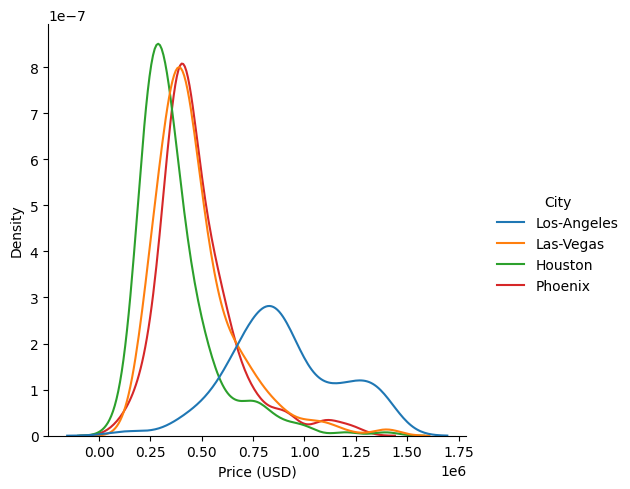

In [125]:
sns.displot(df_modify, x='Price (USD)', hue='City', kind='kde')

Nhìn vào biểu đồ ta có thể thấy:
- Giá của LV, Houston, Phoenix đều tương quan bằng nhau
- Giá của LA thì cao hơn so với 3 thành phố kia\
$\rightarrow$ trung bình giá của LA và các thành phố khác có độ chênh lệch là **500000 $**
- Ta sẽ đặt giả thuyết giữa 2 thành phố: **Los-Angeles và Houston**

$$H_0: \mu_1 - \mu_2 = 500000$$
$$H_1: \mu_1 - \mu_2 > 500000$$
- Trong đó:\
$\mu_1$: mean Los-Angeles\
$\mu_2$: mean Houston

In [126]:
#Tính mean_1 và mean_2
mean_1 = round(los_angeles['Price (USD)'].mean(), 3)
mean_2 = round(houston['Price (USD)'].mean(), 3)
delta_0 = 500000

#Tính standard deviation
std_1 = round(los_angeles['Price (USD)'].std(), 3)
std_2 = round(houston['Price (USD)'].std(), 3)

#Tính n
n_1 = len(los_angeles)
n_2 = len(houston)

In [127]:
#Tính z_0
z = (mean_1-mean_2 - delta_0)/(np.sqrt((std_1**2/n_1)+(std_2**2/n_2)))

In [128]:
#Tính lower, upper
z_scores = stats.norm.ppf(1- alpha)
epsilon = z_scores*np.sqrt((std_1**2/n_1) + (std_2**2/n_2))
upper = mean_1-mean_2+epsilon

In [129]:
if z > upper:
    print("Reject H0")
else:
    print("Fail to reject H0")

Fail to reject H0


- Ta sẽ đặt giả thuyết về giá giữa 2 thành phố trong 3 thành phố tương đối bằng nhau:
- Đặt giả thuyết về độ lệch giá trung bình của 2 thành phố: **Las-Vegas và Houston**

$$H_0: \mu_1 - \mu_2 = 100000$$
$$H_1: \mu_1 - \mu_2 < 100000$$
- Trong đó:\
$\mu_1$: mean Las-Vegas\
$\mu_2$: mean Houston

In [130]:
#Tính mean_1 và mean_2
mean_1 = round(las_vegas['Price (USD)'].mean(), 3)
mean_2 = round(houston['Price (USD)'].mean(), 3)
delta_0 = 100000

#Tính standard deviation
std_1 = round(las_vegas['Price (USD)'].std(), 3)
std_2 = round(houston['Price (USD)'].std(), 3)

#Tính n
n_1 = len(las_vegas)
n_2 = len(houston)

In [131]:
#Tính z_0
z = (mean_1 - mean_2 - delta_0)/np.sqrt((std_1**2/n_1) + (std_2**2/n_2))

In [132]:
#Tính lower
z_scores = stats.norm.ppf(1-alpha)
epsilon = z_scores*np.sqrt((std_1**2/n_1) + (std_2**2/n_2))
lower = mean_1 - mean_2 - epsilon

In [133]:
if z < lower:
    print("Reject H0")
else:
    print("Fail to reject H0")

Reject H0


Từ 2 giả thuyết trên, ta có thể thấy:
- Đối với giả thuyết 1: Độ lệch trung bình của 2 thành phố **Los-Angeles và Houston** = 500000 là đúng vì $Z_0$ **nằm trong** giới hạn của Confident Interval.\
$\rightarrow$ **Fail to reject $H_0$** ($H_0$ Đúng)
- Đối với giả thuyết 2: Độ lệch trung bình của 2 thành phố **Las-Vegas và Houston** = 100000 là sai vì $Z_0$ **nằm ngoài** giới hạn của Confident Interval.\
$\rightarrow$ **Reject $H_0$** ($H_0$ Sai)

# Hồi quy:

RMSE: 318.50421485985004


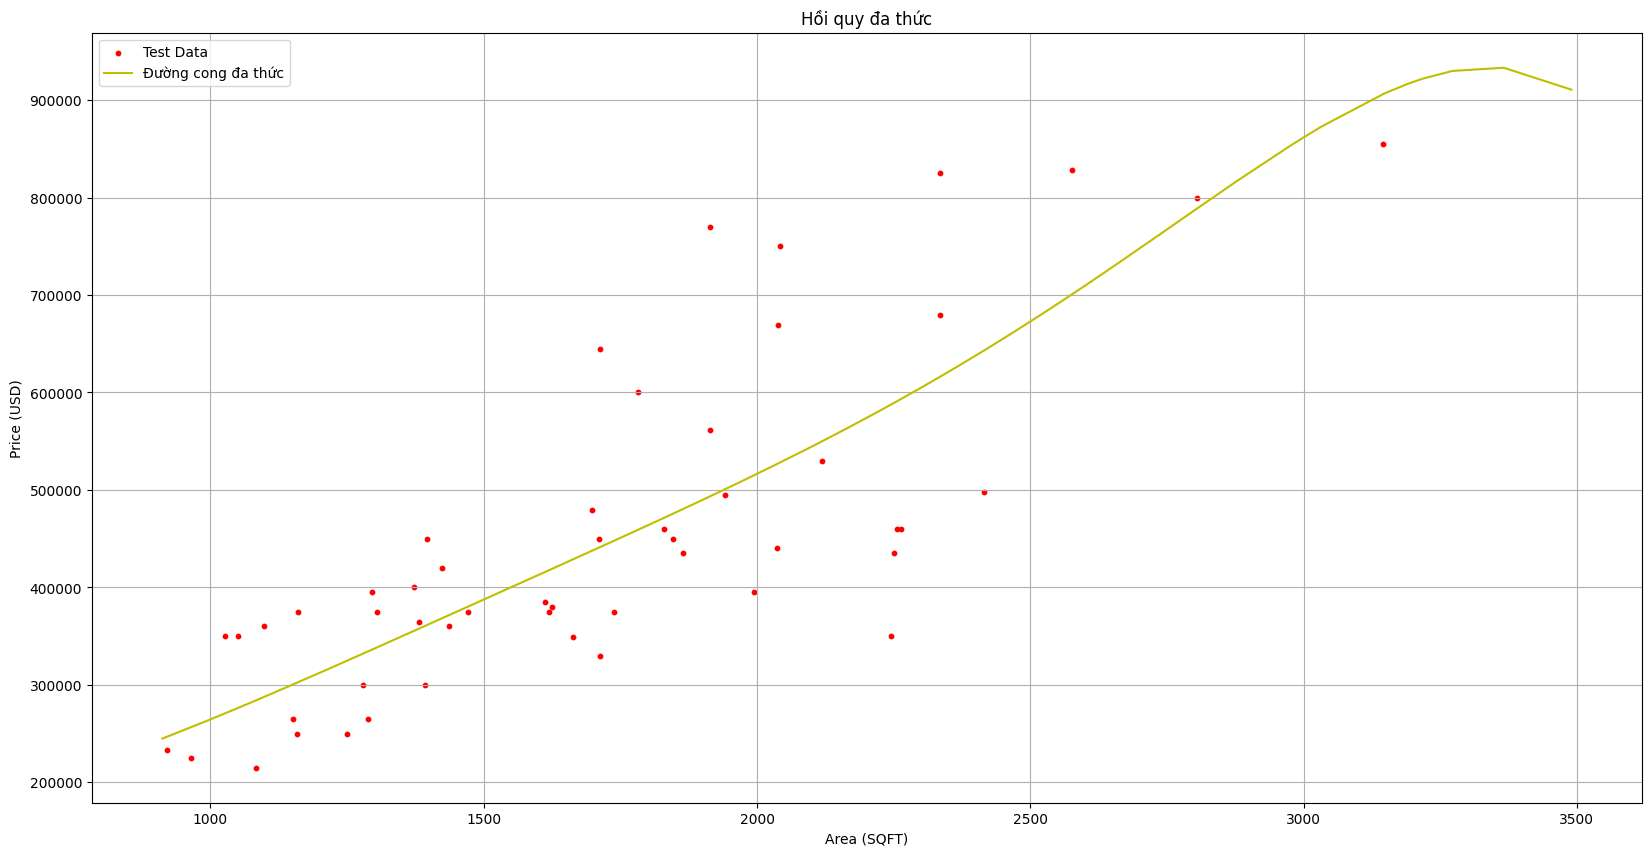

In [148]:
# Tạo dữ liệu mẫu từ DataFrame
x = las_vegas['Area (SQFT)'].values.reshape(-1, 1)
y = las_vegas['Price (USD)'].values.reshape(-1, 1)

# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

# Tạo biến đa thức (bậc 6)
polynomial_features = PolynomialFeatures(degree=6)
x_poly = polynomial_features.fit_transform(x_train)

# Khớp mô hình hồi quy tuyến tính
model = LinearRegression()
model.fit(x_poly, y_train)

# Dự đoán trên tập kiểm tra
x_poly_test = polynomial_features.transform(x_test) 
y_pred = model.predict(x_poly_test)

# Đánh giá mô hình (RMSE)
rmse = np.sqrt(root_mean_squared_error(y_test, y_pred))
print("RMSE:", rmse)

# Dự đoán trên tập huấn luyện để vẽ đường cong
x_poly_train = polynomial_features.transform(x_train)  
y_train_pred = model.predict(x_poly_train)


# Vẽ biểu đồ
plt.figure(figsize=(20,10))
# plt.scatter(x_train, y_train, s=10, label='Train Data')
plt.scatter(x_test, y_test, s=10, label = 'Test Data', color='r')
# Sắp xếp x_train và y_train_pred để vẽ đường cong mượt mà
sort_axis = operator.itemgetter(0)
sorted_zip = sorted(zip(x_train, y_train_pred), key=sort_axis)
x_train_sorted, y_train_pred_sorted = zip(*sorted_zip)
plt.plot(x_train_sorted, y_train_pred_sorted, color='y', label='Đường cong đa thức')
plt.ylabel('Price (USD)')
plt.xlabel('Area (SQFT)')
plt.title('Hồi quy đa thức')
plt.legend()
plt.grid(True)
plt.show()